In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'


In [2]:
import sys

sys.path.append("/home/caio/dev/")

In [3]:

from torch.utils.data import DataLoader, random_split
import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from bprMf.evaluation import Evaluator
from bprMf.bpr_mf import bprMf

In [4]:
device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

'cpu'

In [5]:
# ml_dirty = pd.read_csv('movielens_1m.csv').rename(columns={'Rating': 'rating'})

In [6]:

#ml_dirty.to_csv('movielens_1m_ratings.csv')

In [7]:
df = pd.read_csv("ml_1m.csv")

In [8]:
df

,item,genres,user,rating,timestamp,binarized_rating
0,0,"['animation', ""children's"", 'comedy']",0,5,978824268,1
1,0,"['animation', ""children's"", 'comedy']",5,4,978237008,1
2,0,"['animation', ""children's"", 'comedy']",7,4,978233496,1
3,0,"['animation', ""children's"", 'comedy']",8,5,978225952,1
4,0,"['animation', ""children's"", 'comedy']",9,5,978226474,1
...,...,...,...,...,...,...
982035,3705,"['drama', 'thriller']",5811,4,992072099,1
982036,3705,"['drama', 'thriller']",5830,3,986223125,0
982037,3705,"['drama', 'thriller']",5836,4,1011902656,1
982038,3705,"['drama', 'thriller']",5926,1,979852537,0


## Developing a MF model based using BPR opt


Now we'll generalize the previous implementation using implicit feedback data and applying BPR (Bayesian personalized ranking) loss function, so that the model is capable of building personalzied rankings for users

### Step 2: Create a MF model using BPR loss function

In [9]:

n_users = df.user.max() + 1
n_items = df.item.max() + 1

In [10]:
n_users, n_items

(np.int64(6040), np.int64(3706))

In [11]:
items = df["item"].drop_duplicates()
users = df["user"].drop_duplicates()

users_tensor = torch.tensor(users, dtype=torch.long, device=device)

In [12]:



model = bprMf(
                num_users=n_users,
                num_items=n_items,
                factors=50,
                reg_lambda=5e-4,
                n_epochs=2,
                dev=device)

In [13]:
interactions = df[["user", "item", "binarized_rating"]].rename(
    columns={"binarized_rating": "relevant"}
)

In [14]:
train_frac = 0.7

train_df = interactions.sample(frac=train_frac, random_state=42)

test_df = interactions.drop(train_df.index)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [15]:
interactions

,user,item,relevant
0,0,0,1
1,5,0,1
2,7,0,1
3,8,0,1
4,9,0,1
...,...,...,...
982035,5811,3705,1
982036,5830,3705,0
982037,5836,3705,1
982038,5926,3705,0


In [16]:
test_df

,user,item,relevant
0,5,0,1
1,8,0,1
2,17,0,1
3,25,0,0
4,43,0,1
...,...,...,...
294607,4830,3705,1
294608,5358,3705,1
294609,5601,3705,0
294610,5681,3705,0


In [17]:

train_losses = model.fit(train_df, lr=1e-3)

Epochs: 100%|██████████| 2/2 [00:45<00:00, 22.72s/it]


In [18]:
train_losses

[0.301332086947023, 0.20082468831218325]

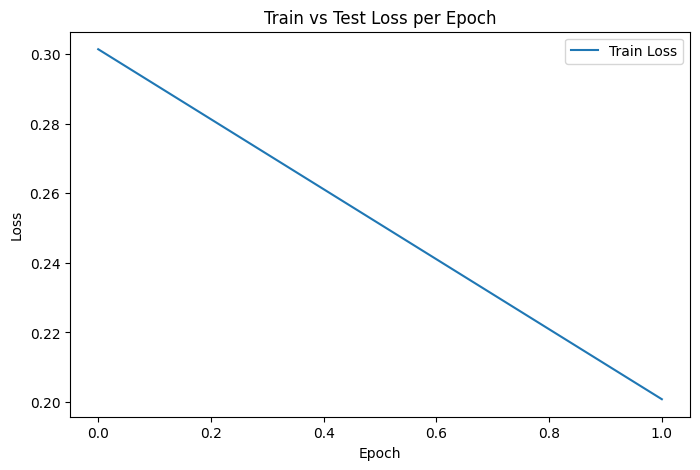

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.show()

In [20]:
items = df["item"].drop_duplicates()
users = df["user"].drop_duplicates()

users_tensor = torch.tensor(users, dtype=torch.long, device=device)
items_tensor = torch.tensor(items, dtype=torch.long, device=device)

In [21]:
u_stack, i_stack, s_stack = model.predict(users_tensor, items_tensor)

In [22]:
users.max().item()

6039

In [23]:
len(users)

5289

In [24]:
model.score(df) 

,user,top_k_rec_id,top_k_rec_score
0,0,"[2203, 2651, 1108, 513, 1107, 858, 33, 1173, 8...","[5.8774495124816895, 5.309165954589844, 5.2476..."
1,5,"[2203, 346, 583, 525, 1574, 2162, 1107, 1441, ...","[4.920882701873779, 4.838586330413818, 4.65594..."
2,7,"[2651, 593, 287, 309, 49, 513, 1848, 579, 2557...","[6.0741472244262695, 5.995275020599365, 5.9911..."
3,8,"[2651, 287, 2374, 2557, 2785, 1848, 593, 309, ...","[6.206329822540283, 5.795092582702637, 5.78051..."
4,9,"[1899, 1107, 1900, 963, 1178, 1906, 1108, 581,...","[5.136825084686279, 5.099380970001221, 5.07841..."
...,...,...,...
5284,4060,"[253, 1106, 1131, 852, 847, 1212, 802, 1848, 1...","[2.6959424018859863, 2.6285886764526367, 2.612..."
5285,3234,"[2557, 3510, 3341, 2651, 2374, 2203, 2501, 216...","[3.4816434383392334, 3.478437662124634, 3.4075..."
5286,3297,"[2651, 2374, 2501, 2557, 2162, 1449, 2495, 346...","[5.178315162658691, 5.161028861999512, 5.13529..."
5287,767,"[2501, 3510, 2490, 2557, 3383, 2480, 2346, 293...","[3.2544021606445312, 3.0907633304595947, 2.965..."


In [25]:
model.score(test_df)

,user,top_k_rec_id,top_k_rec_score
0,5,"[2203, 346, 583, 525, 1574, 2162, 1107, 1441, ...","[4.920882701873779, 4.838586330413818, 4.65594..."
1,8,"[2651, 287, 2374, 2557, 2785, 1848, 593, 309, ...","[6.206329822540283, 5.795092582702637, 5.78051..."
2,17,"[2374, 1107, 1106, 1108, 1178, 253, 1449, 1120...","[4.535804271697998, 4.463641166687012, 4.35047..."
3,25,"[583, 346, 525, 2203, 1574, 2469, 573, 309, 30...","[4.241374969482422, 4.228664398193359, 4.14009..."
4,43,"[1107, 1106, 1178, 253, 1108, 1120, 2374, 1449...","[4.966073989868164, 4.865715026855469, 4.81190..."
...,...,...,...
5284,2244,"[2374, 2651, 2557, 2501, 3341, 3510, 3550, 184...","[3.8202247619628906, 3.7461373805999756, 3.741..."
5285,1036,"[2651, 2557, 2203, 1848, 3341, 309, 3177, 593,...","[4.955380916595459, 4.464457035064697, 4.40383..."
5286,4060,"[253, 1106, 1131, 852, 847, 1212, 802, 1848, 1...","[2.6959424018859863, 2.6285886764526367, 2.612..."
5287,4895,"[2401, 2765, 3302, 3072, 3102, 3384, 2488, 294...","[2.2769687175750732, 2.2715530395507812, 2.232..."
